In [1]:
import GEMVAE

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [3]:
gdata = sc.read_h5ad('./data/Landau/spleen_rep_1/Mouse_Spleen/adata_RNA.h5ad')
gdata.var_names_make_unique()
gdata

AnnData object with n_obs × n_vars = 2653 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [4]:
pdata = sc.read_h5ad('./data/Landau/spleen_rep_1/Mouse_Spleen/adata_Pro.h5ad')
pdata.var_names_make_unique()
pdata

AnnData object with n_obs × n_vars = 2653 × 21
    obsm: 'spatial'

In [5]:
# gdata.obsm=adata.obsm
# gdata.uns = adata.uns
# pdata.obsm=adata.obsm
# pdata.uns = adata.uns

In [6]:
#Normalization Gene
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

#Normalization Protein 
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

------Calculating spatial graph...
The graph contains 20534 edges, 2653 cells.
7.7399 neighbors per cell on average.


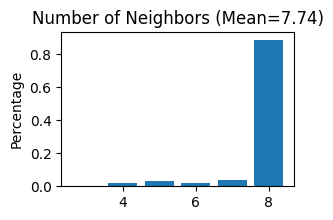

In [7]:
GEMVAE.Cal_Spatial_Net(gdata, rad_cutoff=2)
GEMVAE.Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 20534 edges, 2653 cells.
7.7399 neighbors per cell on average.


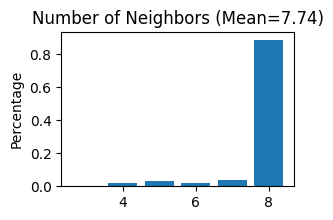

In [8]:
GEMVAE.Cal_Spatial_Net(pdata, rad_cutoff=2)
GEMVAE.Stats_Spatial_Net(pdata)

In [9]:
# hyper parameters 
epochs = 400
hidden_dims_gene = [512,30]
hidden_dims_pro = [128, 30]

#cell-type aware params
alpha = 0.45
pre_resolution_gene = 0.55
pre_resolution_pro = 0.25
save_loss = True

# Loss weights
kl_loss = 0
contrastive_loss = 10
weight_decay_loss = 1      #Loss for Ateentions Layers
recon_loss_type = 'ZINB'      # ZINB or MSE
recon_loss = 1

Size of Input for gene data :  (2653, 3000)
Size of Input for protein data :  (2653, 21)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loss weights are =  10 1 1 0
START TRAIN
------Pre-clustering Genes using louvain with resolution=0.55
------Pre-clustering Protein using louvain with resolution=0.25
------Pruning the graph...
20534 edges before pruning.
15600 edges after pruning.
------Pruning the graph...
20534 edges before pruning.
14426 edges after pruning.


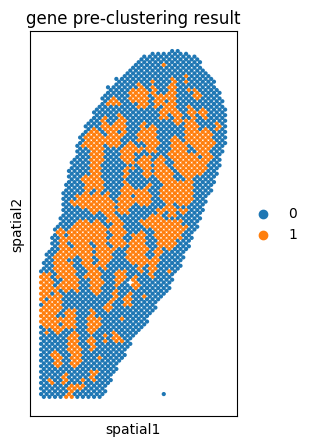

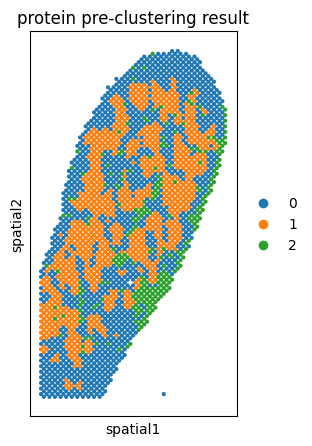

Epoch: 0, Contrastive Loss: 10.0440, Loss: 4524.7642
Epoch: 1, Contrastive Loss: 9.4249, Loss: 4509.1025
Epoch: 2, Contrastive Loss: 9.0103, Loss: 4496.8545
Epoch: 3, Contrastive Loss: 8.8149, Loss: 4504.3965
Epoch: 4, Contrastive Loss: 8.7374, Loss: 4495.4233
Epoch: 5, Contrastive Loss: 8.7116, Loss: 4491.0576
Epoch: 6, Contrastive Loss: 8.7099, Loss: 4481.5820
Epoch: 7, Contrastive Loss: 8.7201, Loss: 4466.7368
Epoch: 8, Contrastive Loss: 8.7358, Loss: 4474.9468
Epoch: 9, Contrastive Loss: 8.7533, Loss: 4462.5908
Epoch: 10, Contrastive Loss: 8.7706, Loss: 4443.1157
Epoch: 11, Contrastive Loss: 8.7862, Loss: 4446.2188
Epoch: 12, Contrastive Loss: 8.8000, Loss: 4426.6133
Epoch: 13, Contrastive Loss: 8.8116, Loss: 4410.1807
Epoch: 14, Contrastive Loss: 8.8211, Loss: 4408.8604
Epoch: 15, Contrastive Loss: 8.8287, Loss: 4393.7676
Epoch: 16, Contrastive Loss: 8.8344, Loss: 4385.3599
Epoch: 17, Contrastive Loss: 8.8387, Loss: 4369.0977
Epoch: 18, Contrastive Loss: 8.8414, Loss: 4363.4629
Ep

In [10]:
trained_gdata = GEMVAE.train_GEMVAE(gdata,pdata,n_epochs=epochs,hidden_dims1=hidden_dims_gene,hidden_dims2=hidden_dims_pro,
                                    alpha=alpha,pre_resolution1=pre_resolution_gene,pre_resolution2=pre_resolution_pro, save_loss=save_loss,
                                    kl_loss = kl_loss,
                                    contrastive_loss = contrastive_loss,
                                    weight_decay_loss = weight_decay_loss,       
                                    recon_loss_type = recon_loss_type,   
                                    recon_loss = recon_loss)

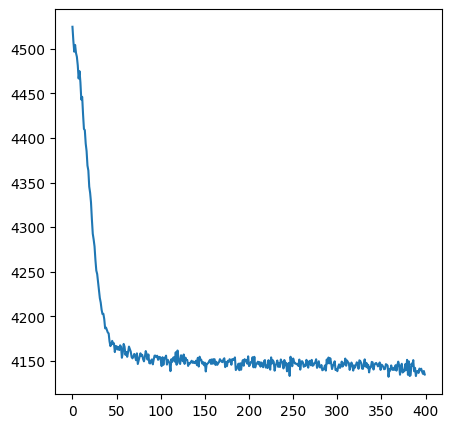

In [11]:
plt.plot(trained_gdata.uns['arch_loss'])
plt.show()

In [12]:
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]

In [13]:
#DEFINE THE NUMBER OF CLUSTERS HERE
n_clusters = 6

In [14]:
for tool in ['mclust','leiden','louvain']:
   # we use mcluster as clustering tool by default.
   print("Using tool : ",tool)

   # performing PCA
   gdata.obsm['emb_combined_pca'] = sc.tl.pca(gdata.obsm['MY_ARCH'])

   # clustering
   if tool == 'mclust':
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='1', n_clusters=n_clusters, method=tool)
   elif tool in ['leiden']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='2', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.04)
   elif tool in ['louvain']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='3', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.04)

Using tool :  mclust


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Using tool :  leiden
Searching resolution...
resolution=1.29, cluster number=8
resolution=1.25, cluster number=8
resolution=1.21, cluster number=8
resolution=1.17, cluster number=8
resolution=1.1300000000000001, cluster number=8
resolution=1.09, cluster number=8
resolution=1.05, cluster number=8
resolution=1.01, cluster number=8
resolution=0.97, cluster number=7
resolution=0.93, cluster number=7
resolution=0.89, cluster number=7
resolution=0.85, cluster number=7
resolution=0.81, cluster number=7
resolution=0.77, cluster number=7
resolution=0.73, cluster number=5
resolution=0.6900000000000001, cluster number=6
Using tool :  louvain
Searching resolution...
resolution=1.29, cluster number=8
resolution=1.25, cluster number=7
resolution=1.21, cluster number=8
resolution=1.17, cluster number=7
resolution=1.1300000000000001, cluster number=7
resolution=1.09, cluster number=6


Visualizing the clusters

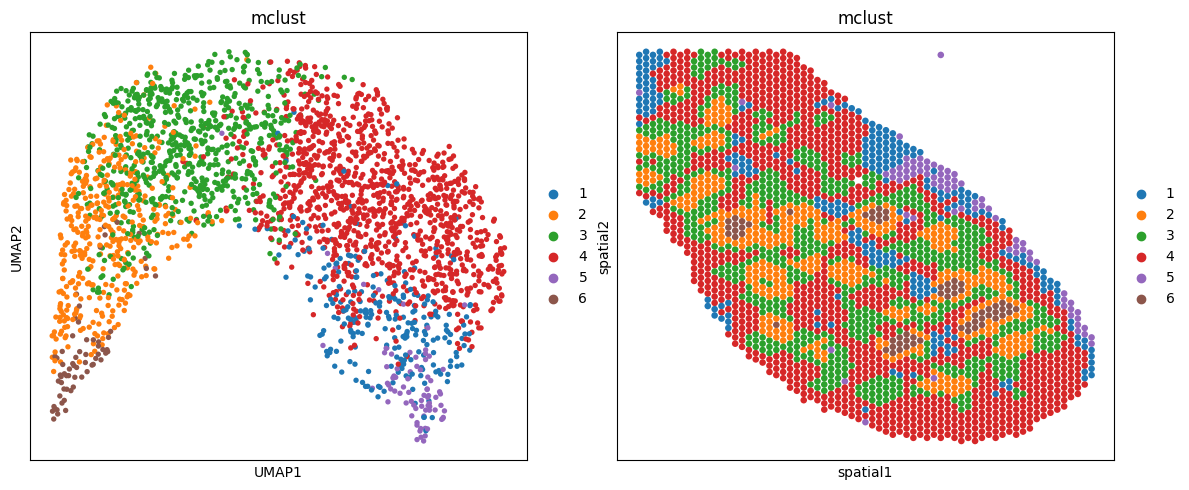

In [18]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

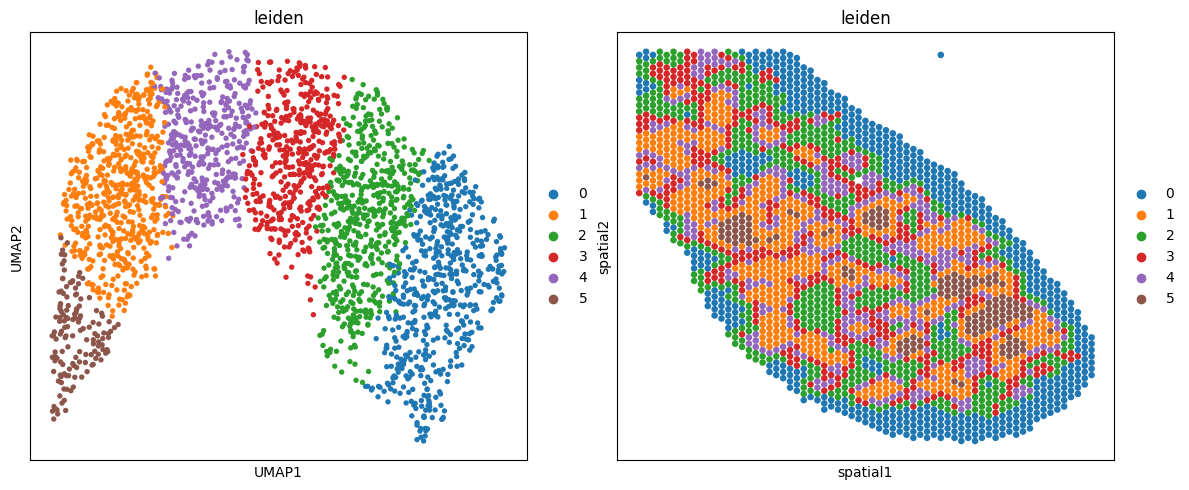

In [16]:
# visualization leiden
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='2', ax=ax_list[0], title='leiden', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='2', ax=ax_list[1], title='leiden', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

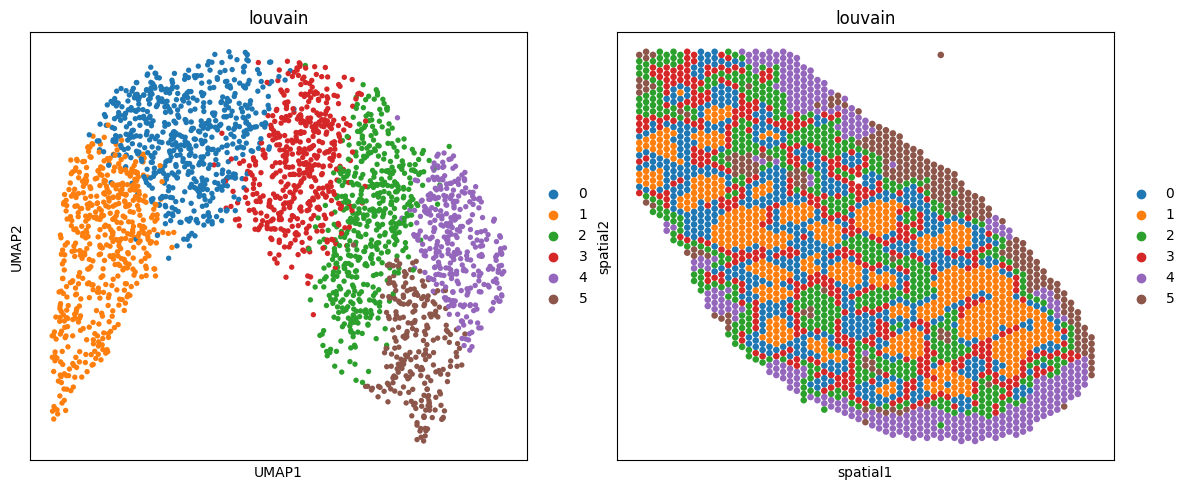

In [17]:
# visualization louven
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='3', ax=ax_list[0], title='louvain', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='3', ax=ax_list[1], title='louvain', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()